# On-Time Delivery Prediction (Logistics ML)

## Purpose
The goal of this notebook is to build a simple machine learning model that predicts whether a shipment will be delivered **on time** based on shipment characteristics such as **distance, weight, carrier, and cost**.

## ML Question
**Can we predict if a shipment will be On-Time or Delayed using shipment features (Distance, Weight, Cost, Carrier, etc.)?**

- Predict if a shipment will be **On-Time (1)** or **Delayed (0)** using shipment features like distance, weight, cost, and carrier.

**Simple target definition:** Since we don’t have promised ETA, we label a shipment as **On-Time** if its `Transit_Days` is less than or equal to the **median Transit_Days of that carrier**.

## Why this matters (logistics context)
In logistics operations, predicting delay risk early helps teams:
- proactively communicate with customers,
- prioritize high-risk shipments,
- improve carrier and route decisions.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [2]:
df = pd.read_csv("logistics_shipments_feature_engineered.csv")

print(df.shape)
df.head()

(1932, 15)


,Shipment_ID,Origin_Warehouse,Destination,Carrier,Shipment_Date,Delivery_Date,Weight_kg,Cost,Status,Distance_miles,Transit_Days,Cost_per_mile,Cost_per_kg,Ship_Month,Route
0,SH10000,Warehouse_MIA,San Francisco,UPS,2023-10-02,2023-10-04,25.7,67.46,Delivered,291,2,0.231821,2.624903,10,Warehouse_MIA → San Francisco
1,SH10001,Warehouse_MIA,Atlanta,DHL,2023-12-06,2023-12-09,38.9,268.85,Delivered,1225,3,0.219469,6.911311,12,Warehouse_MIA → Atlanta
2,SH10002,Warehouse_LA,Houston,DHL,2023-09-18,2023-09-20,37.2,74.35,Delivered,220,2,0.337955,1.998656,9,Warehouse_LA → Houston
3,SH10003,Warehouse_BOS,Seattle,OnTrac,2023-01-26,2023-02-04,42.6,187.04,Delivered,1156,8,0.161799,4.390610,1,Warehouse_BOS → Seattle
4,SH10004,Warehouse_SF,Dallas,OnTrac,2023-06-03,2023-06-06,7.9,120.01,Delivered,1017,3,0.118004,15.191139,6,Warehouse_SF → Dallas


In [3]:
# Keep only rows that matter for this ML task
needed_cols = ["Carrier", "Distance_miles", "Weight_kg", "Cost", "Transit_Days"]
df_ml = df.dropna(subset=needed_cols).copy()

# If you have Status column, keep Delivered only
if "Status" in df_ml.columns:
    df_ml = df_ml[df_ml["Status"].astype(str).str.lower() == "delivered"].copy()

# Remove invalid values
df_ml = df_ml[
    (df_ml["Distance_miles"] > 0) &
    (df_ml["Weight_kg"] > 0) &
    (df_ml["Cost"] > 0) &
    (df_ml["Transit_Days"] >= 0)
].copy()

print("After cleaning:", df_ml.shape)
df_ml.head()

After cleaning: (1585, 15)


,Shipment_ID,Origin_Warehouse,Destination,Carrier,Shipment_Date,Delivery_Date,Weight_kg,Cost,Status,Distance_miles,Transit_Days,Cost_per_mile,Cost_per_kg,Ship_Month,Route
0,SH10000,Warehouse_MIA,San Francisco,UPS,2023-10-02,2023-10-04,25.7,67.46,Delivered,291,2,0.231821,2.624903,10,Warehouse_MIA → San Francisco
1,SH10001,Warehouse_MIA,Atlanta,DHL,2023-12-06,2023-12-09,38.9,268.85,Delivered,1225,3,0.219469,6.911311,12,Warehouse_MIA → Atlanta
2,SH10002,Warehouse_LA,Houston,DHL,2023-09-18,2023-09-20,37.2,74.35,Delivered,220,2,0.337955,1.998656,9,Warehouse_LA → Houston
3,SH10003,Warehouse_BOS,Seattle,OnTrac,2023-01-26,2023-02-04,42.6,187.04,Delivered,1156,8,0.161799,4.390610,1,Warehouse_BOS → Seattle
4,SH10004,Warehouse_SF,Dallas,OnTrac,2023-06-03,2023-06-06,7.9,120.01,Delivered,1017,3,0.118004,15.191139,6,Warehouse_SF → Dallas


In [4]:
# Simple baseline: carrier median transit time
carrier_median = df_ml.groupby("Carrier")["Transit_Days"].median()

# Expected days based on carrier
df_ml["Expected_Days"] = df_ml["Carrier"].map(carrier_median)

# Target: On-Time if transit_days <= carrier median
df_ml["On_Time"] = (df_ml["Transit_Days"] <= df_ml["Expected_Days"]).astype(int)

df_ml[["Carrier", "Transit_Days", "Expected_Days", "On_Time"]].head(10)

,Carrier,Transit_Days,Expected_Days,On_Time
0,UPS,2,4.0,1
1,DHL,3,4.0,1
2,DHL,2,4.0,1
3,OnTrac,8,4.0,0
4,OnTrac,3,4.0,1
5,FedEx,3,4.0,1
6,UPS,4,4.0,1
7,Amazon Logistics,8,4.0,0
8,Amazon Logistics,7,4.0,0
9,LaserShip,2,4.0,1


On_Time
1    895
0    690
Name: count, dtype: int64
On_Time
1    0.564669
0    0.435331
Name: proportion, dtype: float64


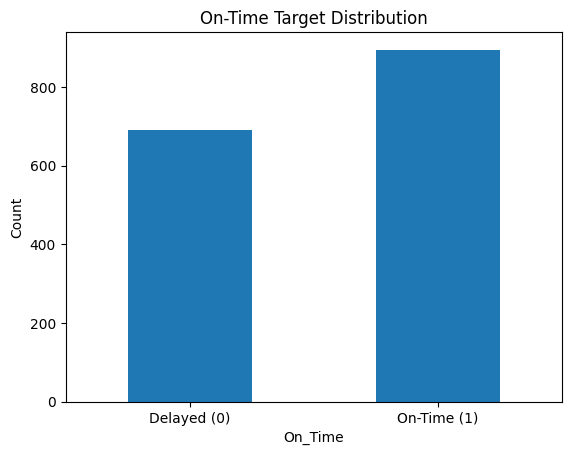

In [5]:
print(df_ml["On_Time"].value_counts())
print(df_ml["On_Time"].value_counts(normalize=True))

# simple plot
df_ml["On_Time"].value_counts().sort_index().plot(kind="bar")
plt.xticks([0,1], ["Delayed (0)", "On-Time (1)"], rotation=0)
plt.title("On-Time Target Distribution")
plt.ylabel("Count")
plt.show()


## Features
We will use a simple feature set:
- Numeric: `Distance_miles`, `Weight_kg`, `Cost`
- Categorical: `Carrier`


In [6]:
X = df_ml[["Distance_miles", "Weight_kg", "Cost", "Carrier"]].copy()
y = df_ml["On_Time"].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train:", X_train.shape, "Test:", X_test.shape)

Train: (1268, 4) Test: (317, 4)


In [7]:
# Separate numeric and categorical columns
numeric_features = ["Distance_miles", "Weight_kg", "Cost"]
categorical_features = ["Carrier"]

# Preprocessing:
# - scale numeric features
# - one-hot encode carrier
preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ]
)

# Model
logreg = LogisticRegression(max_iter=1000)

# Pipeline (preprocess -> model)
model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("logreg", logreg)
])

model

,steps,"[('preprocess', ...), ('logreg', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [8]:
model.fit(X_train, y_train)

,steps,"[('preprocess', ...), ('logreg', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [9]:
y_pred = model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print("Accuracy:", round(acc, 4))

cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", cm)

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, digits=4))

Accuracy: 0.7823

Confusion Matrix:
 [[ 96  42]
 [ 27 152]]

Classification Report:

              precision    recall  f1-score   support

           0     0.7805    0.6957    0.7356       138
           1     0.7835    0.8492    0.8150       179

    accuracy                         0.7823       317
   macro avg     0.7820    0.7724    0.7753       317
weighted avg     0.7822    0.7823    0.7805       317



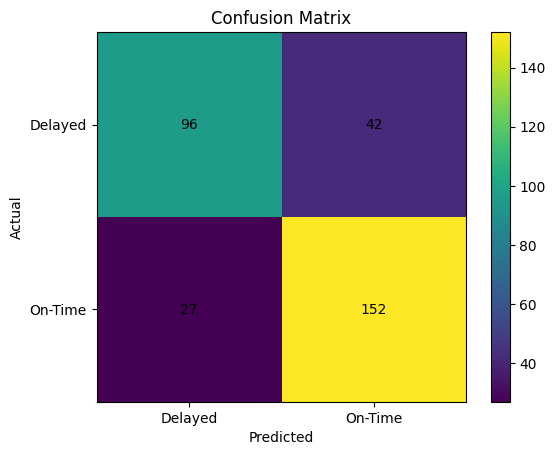

In [10]:
plt.figure()
plt.imshow(cm)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks([0,1], ["Delayed", "On-Time"])
plt.yticks([0,1], ["Delayed", "On-Time"])

for (i, j), val in np.ndenumerate(cm):
    plt.text(j, i, str(val), ha="center", va="center")

plt.colorbar()
plt.show()

### Conclusion

The logistic regression model achieved an overall accuracy of 78.2%, demonstrating a strong ability to predict whether a shipment will be delivered on time using basic shipment features such as distance, weight, cost, and carrier. The confusion matrix and classification report show that the model performs well for both classes, with particularly strong recall (84.9%) for on-time shipments, indicating it is effective at correctly identifying shipments that are likely to arrive as expected. While performance on delayed shipments is slightly lower, the model still captures a majority of delay cases, making it useful for early risk identification. Overall, these results indicate that even a simple, interpretable model can provide meaningful insights into delivery reliability and support proactive decision-making in logistics operations.